# Rayleigh-Marchenko redatuming data preparation for library

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import segyio

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import cg, lsqr
from scipy.signal import convolve, filtfilt
from scipy.io import loadmat

from pylops                            import LinearOperator
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.waveeqprocessing.marchenko import *
from pylops.optimization.leastsquares  import *

from pymarchenko.raymarchenko import RayleighMarchenko

In [2]:
inputfile = '../data/marchenko/input.npz' # choose file in testdata folder of repo

inputdatamck = np.load(inputfile)
inputdatamck.files

['Gsub', 'G0sub', 'vs', 's', 'r', 't', 'rho', 'x', 'wav', 'R', 'z']

In [3]:
inputdatamck['t'].shape, inputdatamck['R'].shape

((800,), (101, 101, 800))

## Inputs

In [4]:
inputfile = '/home/ravasim/Documents/Data/Shynclinal_flatwavelet_dualsensor/input_dualsensor.npz' # choose file in testdata folder of repo
outputfile = '../data/raymarchenko/input.npz'
outputtestfile = '../testdata/raymarchenko/input.npz'

vel = 2400.0        # velocity
tsoff = 0.06        # direct arrival time shift source side
troff = 0.06        # direct arrival time shift receiver side
nsmooth = 10        # time window smoothing 
nfmax = 550         # max frequency for MDC (#samples)
nstaper = 11        # source/receiver taper lenght
n_iter = 30         # iterations
kt = 120            # portion of time axis to remove
convolvedata = True # Apply convolution to data
kind = 'full' # 'full' or 'test'

if kind == 'full':
    jr = 1           # subsampling in r
    js = 2           # subsampling in s
else:
    jr = 2           # subsampling in r
    js = 3           # subsampling in s'

In [5]:
inputdata = np.load(inputfile)

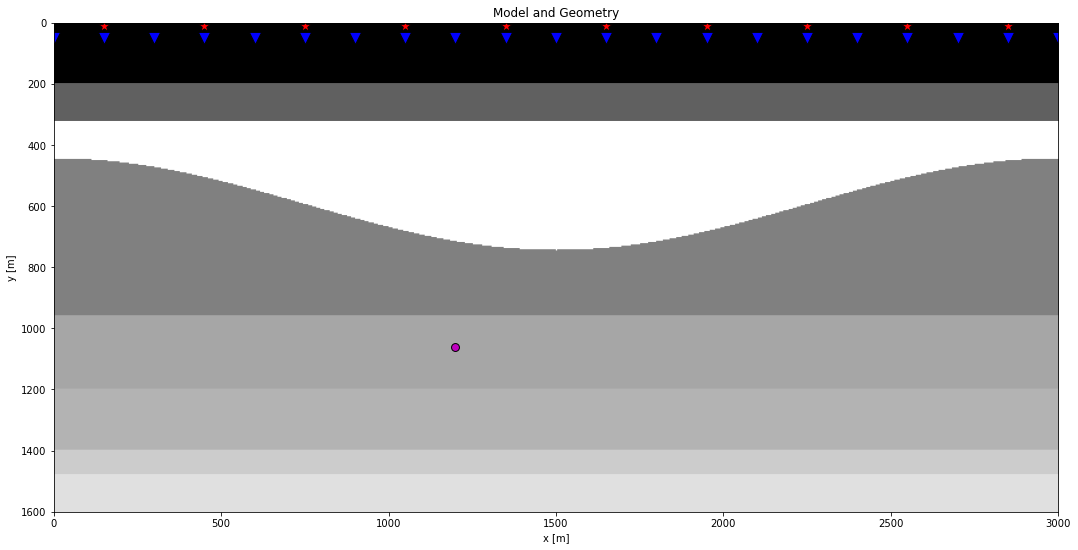

In [6]:
# Receivers
r = inputdata['r'][:,::jr]
nr = r.shape[1]
dr = r[0,1]-r[0,0]

# Sources
s = inputdata['s'][:,::js]
ns = s.shape[1]
ds = s[0,1]-s[0,0]

# Virtual points
vs = inputdata['vs']

# Density model
rho = inputdata['rho']
z, x = inputdata['z'], inputdata['x']

plt.figure(figsize=(18,9))
plt.imshow(rho, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(s[0, 5::10], s[1, 5::10], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(r[0, ::10],  r[1, ::10], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(vs[0], vs[1], marker='.', s=250, c='m', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1]);

In [7]:
# time axis
t = inputdata['t']
ot, dt, nt = t[0], t[1]-t[0], len(t)

# separated data
d = loadmat('/home/ravasim/Documents/Data/Shynclinal_flatwavelet_dualsensor/separated_data.mat')
Vzu = d['VUP'][:,::jr,::js]
Vzd = d['VDOWN'][:,::jr,::js]
wav = inputdata['wav']
wav = wav / np.max(np.abs(np.fft.fft(wav))*dt)
wav_c = np.argmax(wav)

In [8]:
# remove early time
Vzu = Vzu[kt:]
Vzd = Vzd[kt:]
t = t[:-kt]
nt = len(t)

Read subsurface fields and wavelet to apply to subsurface fields

In [9]:
Gsub = inputdata['Gsub'][:, ::js]
G0sub = inputdata['G0sub'][:, ::jr]
Gsub = Gsub[kt:]
G0sub = G0sub[kt:]

In [10]:
if kind == 'full':
    np.savez(outputfile, Gsub=Gsub, G0sub=G0sub, vs=vs, s=s, r=r, t=t, rho=rho, x=x, wav=wav, 
             Vzu=Vzu.transpose(2, 1, 0), Vzd=Vzd.transpose(2, 1, 0), z=z)
else:
    itmax = 1000
    np.savez(outputtestfile, Gsub=Gsub[:itmax].astype(np.float32), G0sub=G0sub[:itmax].astype(np.float32), 
             vs=vs, s=s, r=r, t=t[:itmax], rho=rho, x=x, wav=wav, 
             Vzu=Vzu[:itmax].transpose(2, 1, 0).astype(np.float32), 
             Vzd=Vzd[:itmax].transpose(2, 1, 0).astype(np.float32), z=z)